# Дашборд

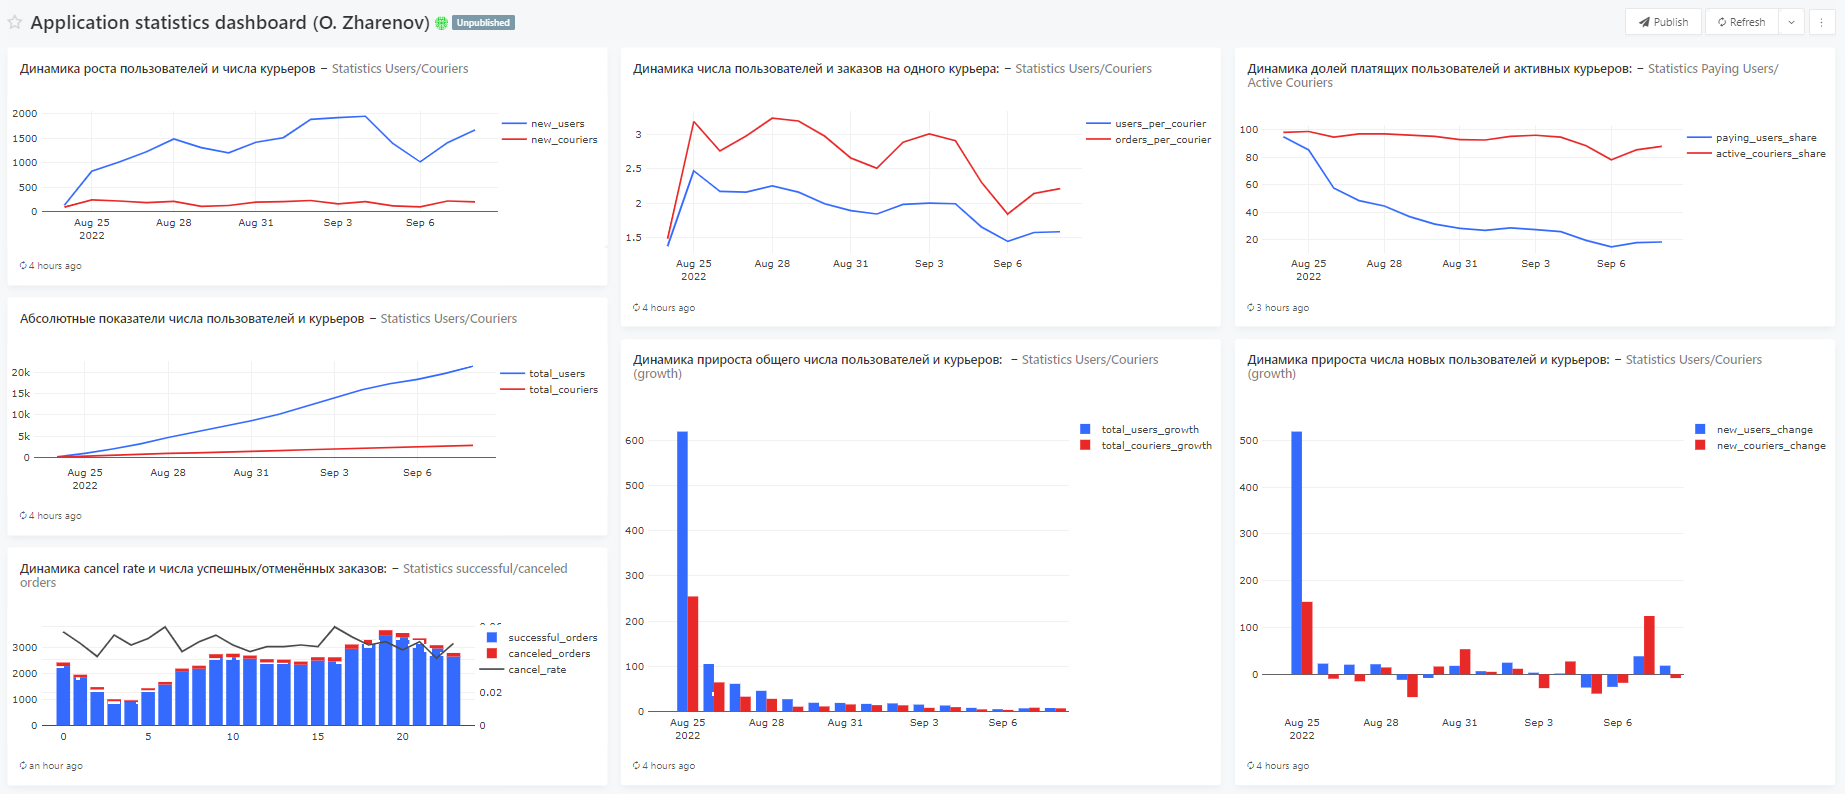

In [ ]:
"""
Динамика числа пользователей и курьеров


select 
    t1.date, 
    new_users, 
    new_couriers,
    (SUM(new_users) OVER(ORDER BY t1.date))::int total_users,
    (SUM(new_couriers) OVER(ORDER BY t1.date))::int total_couriers
from 
(
    select date, count(user_id) as new_users
    from
    (
        select 
            min(time::date) as date,
            user_id
        from user_actions
        group by user_id
    ) as ua
    group by date
) as t1 
full join
(
    select date, count(courier_id) as new_couriers
    from
    (
        select min(time::date) as date, courier_id
        from courier_actions
        group by courier_id
    ) as ca
    group by date
) as t2
on t1.date = t2.date
order by date
"""

In [ ]:
"""
Прирост числа новых пользователей.
Прирост числа новых курьеров.
Прирост общего числа пользователей.
Прирост общего числа курьеров.


select 
    date,
    new_users,
    new_couriers,
    total_users,
    total_couriers,
    new_users_change,
    new_couriers_change,
    ROUND(100*total_users::decimal / LAG(total_users, 1) OVER() - 100, 2)  total_users_growth,
    ROUND(100*total_couriers::decimal / LAG(total_couriers, 1) OVER() - 100, 2)  total_couriers_growth
FROM
(
    SELECT t1.date,
           new_users,
           new_couriers,
           (sum(new_users) OVER(ORDER BY t1.date))::int total_users,
           (sum(new_couriers) OVER(ORDER BY t1.date))::int total_couriers,
           ROUND(100*new_users::decimal / LAG(new_users, 1) OVER() - 100, 2)  new_users_change,
           ROUND(100*new_couriers::decimal / LAG(new_couriers, 1) OVER() - 100, 2)  new_couriers_change
    FROM   (SELECT date,
                   count(user_id) as new_users
            FROM   (SELECT min(time::date) as date,
                           user_id
                    FROM   user_actions
                    GROUP BY user_id) as ua
            GROUP BY date) as t1 full join (SELECT date,
                                           count(courier_id) as new_couriers
                                    FROM   (SELECT min(time::date) as date,
                                                   courier_id
                                            FROM   courier_actions
                                            GROUP BY courier_id) as ca
                                    GROUP BY date) as t2
            ON t1.date = t2.date
    ORDER BY date
) as final
"""

In [ ]:
"""
Число платящих пользователей.
Число активных курьеров.
Долю платящих пользователей в общем числе пользователей на текущий день.
Долю активных курьеров в общем числе курьеров на текущий день.


select
    t1.date,
    paying_users,
    active_couriers,
    ROUND(100*paying_users::decimal / SUM(new_user) OVER(ORDER BY t1.date)::int, 2) paying_users_share,
    ROUND(100*active_couriers::decimal / SUM(new_courier) OVER(ORDER BY t1.date)::int, 2) active_couriers_share
from
(
select
    ca.date,
    paying_users,
    active_couriers
from
(
    select 
        time::date as date, count(distinct user_id) paying_users
    from user_actions
    where order_id not in (select order_id from user_actions where action = 'cancel_order')
    group by date
) as ua join
(
    select 
        time::date as date, count(distinct courier_id) active_couriers
    from courier_actions
    where action = 'accept_order' and 
        order_id in (select order_id from courier_actions where action = 'deliver_order')
    group by date
) as ca
on ca.date = ua.date
) as t1
join
(
    select 
        ca2.date,
        new_user,
        new_courier
    from
    (
        select date, count(user_id) new_user
        from
        (
            select min(time::date) as date, user_id
            from user_actions
            group by user_id
        ) as ua1
        group by date
    ) as ua2
    join
    (
        select date, count(courier_id) new_courier
        from
        (
            select min(time::date) as date, courier_id
            from courier_actions
            group by courier_id
        ) as ca1
        group by date
    ) as ca2
    on ua2.date = ca2.date
) as t2
on t1.date = t2.date
order by t1.date
"""

In [ ]:
"""
Для каждого дня, представленного в таблице user_actions, рассчитайте следующие показатели:
Долю пользователей, сделавших в этот день всего один заказ, в общем количестве платящих пользователей.
Долю пользователей, сделавших в этот день несколько заказов, в общем количестве платящих пользователей.


select 
    t1.date, 
    round(100*single_order_users_share::decimal / (single_order_users_share + several_orders_users_share), 2) as single_order_users_share,
    round(100*several_orders_users_share::decimal / (single_order_users_share + several_orders_users_share), 2) as several_orders_users_share
 from
(
    select date, count(user_id) as single_order_users_share
    from
    (
        select 
            time::date date, 
            user_id, 
            count(distinct order_id) cnt
        from user_actions
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
        group by date, user_id
        having count(distinct order_id) = 1
    ) as t_equal_1
    group by date
) as t1
full join
(
    select date, count(user_id) as several_orders_users_share
    from
    (
        select 
            time::date date, 
            user_id, 
            count(distinct order_id) cnt
        from user_actions
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
        group by date, user_id
        having count(distinct order_id) > 1
    ) as t_more_1
    group by date
) as t2
on t1.date = t2.date
"""

In [ ]:
"""
Для каждого дня, представленного в таблице user_actions, рассчитайте следующие показатели:

Общее число заказов.
Число первых заказов (заказов, сделанных пользователями впервые).
Число заказов новых пользователей (заказов, сделанных пользователями в тот же день, когда они впервые воспользовались сервисом).
Долю первых заказов в общем числе заказов (долю п.2 в п.1).
Долю заказов новых пользователей в общем числе заказов (долю п.3 в п.1).


select
    t1.date,
    orders,
    first_orders, 
    new_users_orders,
    round(100*first_orders::decimal / orders, 2) as first_orders_share,
    round(100*new_users_orders::decimal / orders, 2) as new_users_orders_share
from
(
    select creation_time::date as date, count(order_id) as orders
    from orders
    where order_id not in (select order_id from user_actions where action='cancel_order')
    group by date
) as t1
left join 
(
    select
        date,
        count(user_id) as first_orders
    from
    (
        select min(time::date) as date, user_id
        from user_actions
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
        group by user_id
    ) as ua
    group by date
) as t2 on t1.date = t2.date
left join
(
    select
        ua1.date, count(order_id) as new_users_orders
    from
    (
        select min(time::date) as date, user_id
        from user_actions
        group by user_id
    ) as ua1 left join 
    (
        select time::date as date, user_id, order_id
        from user_actions
        where order_id not in (select order_id from user_actions where action = 'cancel_order')
    ) as ua2 on ua1.user_id = ua2.user_id and ua1.date = ua2.date
    group by ua1.date
) as t3 on t2.date = t3.date
order by t1.date
"""

In [ ]:
"""
Среднее время доставки заказа


select
    t2.date,
    round(avg(EXTRACT('epoch' from time_deliver - time_accept) / 60)) minutes_to_deliver
from
(
    select 
        time::date as date,
        time as time_accept,
        order_id
    from courier_actions
    where action = 'accept_order' and order_id not in (select order_id from user_actions where action = 'cancel_order')
) as t1
left join
(
    select 
        time::date as date,
        time as time_deliver,
        order_id
    from courier_actions
    where action = 'deliver_order' and order_id not in (select order_id from user_actions where action = 'cancel_order')
) as t2 on t1.order_id = t2.order_id
group by t2.date
order by t2.date
"""

In [ ]:
"""
На основе данных в таблице orders для каждого часа в сутках рассчитайте следующие показатели:
Число успешных (доставленных) заказов.
Число отменённых заказов.
Долю отменённых заказов в общем числе заказов (cancel rate).


select
    t1.hour::int,
    successful_orders,
    canceled_orders,
    round(canceled_orders::decimal / (successful_orders + canceled_orders), 3) as cancel_rate
from
(
    select
        date_part('hour', time) as hour,
        count(distinct order_id) successful_orders
    from user_actions
    where action = 'create_order' and order_id not in (select order_id from user_actions where action = 'cancel_order')
    group by hour
) as t1
join
(
    select
        date_part('hour', time) as hour,
        count(distinct order_id) canceled_orders
    from user_actions
    where action = 'create_order' and order_id in (select order_id from user_actions where action = 'cancel_order')
    group by hour
) as t2 on t1.hour = t2.hour
order by t1.hour
"""